In [9]:
import numpy as np
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [10]:
num_gpu = 8
num_class = 10
input_shape = (28, 28, 1)
m_train = 60000
m_test = 10000

batch_size = num_gpu*16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [11]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

11493376/11490434 [==============================] - 0s 0us/step


# Model

In [12]:
model = Sequential([
    Convolution2D(filters=256, kernel_size=(9, 9), strides=1, padding='valid', activation='relu', input_shape=input_shape),
    PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, padding="valid", activation_caps=squash),
    Caps(capsules=num_class, capsule_dim=16, routings=3, activation_caps=squash),
    ClassesCaps(name='capsule'),
])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 20, 256)       20992     
_________________________________________________________________
primary_caps_2 (PrimaryCaps) (None, 1152, 8)           5308672   
_________________________________________________________________
caps_2 (Caps)                (None, 10, 16)            1474560   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 6,804,224
Trainable params: 6,804,224
Non-trainable params: 0
_________________________________________________________________


# Training

In [14]:
model = multi_gpu_model(model, gpus=num_gpu)
model.compile(optimizer=Adam(lr=1e-3),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [15]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=10,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           verbose=1)

Epoch 1/10
468/468 [==============================] - 38s 81ms/step - loss: 0.0903 - categorical_accuracy: 0.9114 - val_loss: 0.0222 - val_categorical_accuracy: 0.9871
Epoch 2/10
468/468 [==============================] - 34s 72ms/step - loss: 0.0212 - categorical_accuracy: 0.9849 - val_loss: 0.0136 - val_categorical_accuracy: 0.9916
Epoch 3/10
468/468 [==============================] - 34s 72ms/step - loss: 0.0153 - categorical_accuracy: 0.9895 - val_loss: 0.0117 - val_categorical_accuracy: 0.9922
Epoch 4/10
468/468 [==============================] - 34s 72ms/step - loss: 0.0129 - categorical_accuracy: 0.9914 - val_loss: 0.0093 - val_categorical_accuracy: 0.9936
Epoch 5/10
468/468 [==============================] - 34s 72ms/step - loss: 0.0107 - categorical_accuracy: 0.9931 - val_loss: 0.0107 - val_categorical_accuracy: 0.9930
Epoch 6/10
468/468 [==============================] - 34s 72ms/step - loss: 0.0099 - categorical_accuracy: 0.9936 - val_loss: 0.0087 - val_categorical_accuracy:

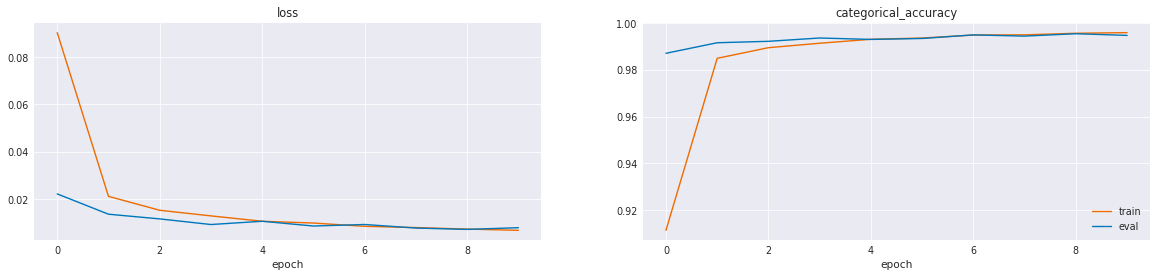

In [16]:
plotHistory(hist.history)